# Solution of 2D Forward Problem of Linear Elasticity for Plane Stress Boundary Value Problem using Physics-Informed Neural Networks (PINN)

### Solve the 2D plane stress problem of elasticity using PINN using PDE and BC losses. Use stochastic gradient descent for training. Penalize the boundary condition loss with a factor of 10,000.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

torch.manual_seed(123456)
np.random.seed(123456)

In [2]:
E = 1                                       # Young's Modulus
nu = 0.3                                    # Poisson Ratio
G =  E/(2*(1+nu))                                       # Shear modulus

In [3]:
Total_loss = []
PDE_loss = []
BC_loss = []

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define your model here (refer: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)
        self.Nnet = nn.Sequential()
        self.Nnet.add_module('Hidden_layer_1', nn.Linear(2,30))    # First linear layer
        self.Nnet.add_module('Tanh_layer_1', nn.Tanh())
        self.Nnet.add_module('Hidden_layer_2', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_2', nn.Tanh())
        self.Nnet.add_module('Hidden_layer_3', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_3', nn.Tanh())
        self.Nnet.add_module('Hidden_layer_4', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_4', nn.Tanh())
        self.Nnet.add_module('Hidden_layer_5', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_5', nn.Tanh())
        self.Nnet.add_module('Output Layer', nn.Linear(30,2))
        
        print(self.Nnet)                                        # Print model summary

    # Forward Feed
    def forward(self, x):
        y = self.Nnet(x)
        return y

    # PDE and BCs loss
    def loss(self, x, x_b, b_u , b_v , epoch):
        y = self.forward(x)   # Interior Solution
        y_b = self.forward(x_b)   # Boundary Solution
        u_b, v_b = y_b[:, 0], y_b[:, 1]     # u and v boundary
        u, v = y[:, 0], y[:, 1]   # u and v interior

        # Calculate Gradients
        # Gradients of deformation in x-direction
        u_g =  gradients(u, x)[0]                    # Gradient of u, Du = [u_x, u_y]
        u_x, u_y = u_g[:, 0], u_g[:, 1]             # [u_x, u_y]
        u_xx = gradients(u_x , x)[0][:, 0]           # Second derivative, u_xx
        u_xy = gradients(u_x , x)[0][:, 1]           # Mixed partial derivative, u_xy
        u_yy = gradients(u_y , x)[0][:, 1]           # Second derivative, u_yy

        # Gradients of deformation in y-direction
        v_g = gradients(v , x)[0]                    # Gradient of v, Du = [v_x, v_y]
        v_x, v_y = v_g[:, 0], v_g[:, 1]             # [v_x, v_y]
        v_xx = gradients(v_x , x)[0][:, 0]           # Second derivative, v_xx
        v_yx = gradients(v_y , x)[0][:, 0]
        v_yy = gradients(v_y , x)[0][:, 1]

        f_1 = torch.sin(2*np.pi*x[:,1])*torch.sin(2*np.pi*x[:,0]) # Define body force for PDE-1
        f_2 =  torch.sin(2 * np.pi * x[:, 1]) + torch.sin(np.pi * x[:, 0])   # Define body force for PDE-2
        
        loss_1 = (G*(u_xx + u_yy) + G*((1+nu)/(1-nu))*(u_xx + v_yx) + f_1)   # Define loss for PDE-1
        loss_2 = (G*(v_xx + v_yy) + G*((1 + nu) / (1 - nu))*(u_xy + v_yy) + f_2)   # Define loss for PDE-2

        loss_PDE = torch.mean((loss_1) ** 2) + torch.mean((loss_2) ** 2)
        loss_bc = torch.mean((u_b - b_u) ** 2) + torch.mean((v_b - b_v) ** 2)

        TotalLoss = loss_PDE + (loss_bc)*10000
        
        Total_loss.append(TotalLoss.detach().numpy())
        PDE_loss.append(loss_PDE.detach().numpy())
        BC_loss.append(loss_bc.detach().numpy()*10000)
        
        if epoch % 100 == 0:
            print(f'epoch {epoch}: loss_pde {loss_PDE:.8f}, loss_bc {loss_bc:.8f}')
            
        return TotalLoss

In [5]:
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),allow_unused=True, create_graph=True)

In [6]:
# Define model parameters here
device = ("cuda" if torch.cuda.is_available() else "cpu")
epochs = 2000                                            # Number of epochs
lr = 0.0005                                                  # Learning Rate

In [7]:

# Load the collocation point data
data = scipy.io.loadmat('interior_points.mat')                     # Import interior points data
x = data['x']                     # Partitioned x coordinates
y = data['y']                            # Partitioned y coordinates
interior_points = np.concatenate((x, y), axis=1)                       # Concatenate (x,y) iterior points

boundary = scipy.io.loadmat('boundary_points.mat')                     # Import boundary points
x_boundary = boundary['x_bdry']                   # Partitioned x boundary coordinates
y_boundary = boundary['y_bdry']                # Partitioned y boundary coordinates

boundary_points = np.concatenate((x_boundary, y_boundary), axis=1)       # Concatenate (x,y) boundary points

u_bound_ext = np.zeros((len(boundary_points)))          # Dirichlet boundary conditions

In [8]:

## Define data as PyTorch Tensor and send to device
xy_f_train = torch.tensor(interior_points, requires_grad=True, dtype=torch.float32).to(device)
xy_b_train = torch.tensor(boundary_points, requires_grad=True, dtype=torch.float32).to(device)

# Define the boundary condition values
u_b_train = torch.tensor(u_bound_ext, dtype=torch.float32).to(device)
v_b_train = torch.tensor(u_bound_ext, dtype=torch.float32).to(device)

# Initialize model
model = Model().to(device)

# Loss and Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Sequential(
  (Hidden_layer_1): Linear(in_features=2, out_features=30, bias=True)
  (Tanh_layer_1): Tanh()
  (Hidden_layer_2): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_2): Tanh()
  (Hidden_layer_3): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_3): Tanh()
  (Hidden_layer_4): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_4): Tanh()
  (Hidden_layer_5): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_5): Tanh()
  (Output Layer): Linear(in_features=30, out_features=2, bias=True)
)


In [9]:
# Training
def train(epoch):
    model.train()

    def closure():
        optimizer.zero_grad()
        loss = model.loss(xy_f_train,xy_b_train,u_b_train,u_b_train,epoch)
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    if epoch % 100 == 0:
            print(f'epoch {epoch}: Total loss {loss:.8f}')
    return loss

In [10]:
for epoch in range(epochs):
    train(epoch+1)

epoch 100: loss_pde 1.21794152, loss_bc 0.00000611
epoch 100: Total loss 1.27905917
epoch 200: loss_pde 1.21767378, loss_bc 0.00000279
epoch 200: Total loss 1.24555218
epoch 300: loss_pde 1.21703196, loss_bc 0.00000258
epoch 300: Total loss 1.24286532
epoch 400: loss_pde 1.21623302, loss_bc 0.00000238
epoch 400: Total loss 1.23999798
epoch 500: loss_pde 1.21527910, loss_bc 0.00000218
epoch 500: Total loss 1.23709810
epoch 600: loss_pde 1.21417022, loss_bc 0.00000201
epoch 600: Total loss 1.23425066
epoch 700: loss_pde 1.21290457, loss_bc 0.00000186
epoch 700: Total loss 1.23149633
epoch 800: loss_pde 1.21147943, loss_bc 0.00000174
epoch 800: Total loss 1.22884691
epoch 900: loss_pde 1.20989048, loss_bc 0.00000164
epoch 900: Total loss 1.22629523
epoch 1000: loss_pde 1.20813298, loss_bc 0.00000157
epoch 1000: Total loss 1.22382522
epoch 1100: loss_pde 1.20620096, loss_bc 0.00000152
epoch 1100: Total loss 1.22141767
epoch 1200: loss_pde 1.20408821, loss_bc 0.00000150
epoch 1200: Total lo

## 1. Plot the displacement field contours in 𝑥− and 𝑦− directions after training the model.

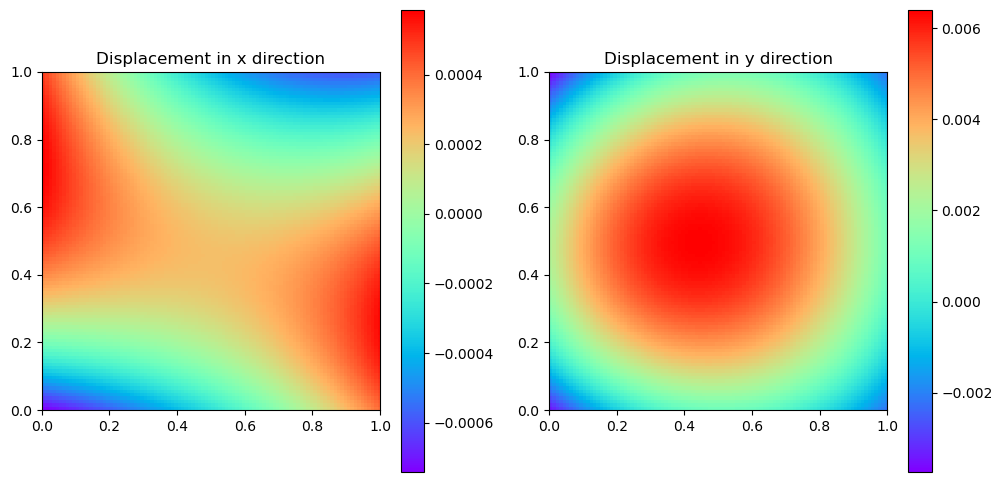

In [21]:
ui_preds = model.forward(xy_f_train)
ub_preds = model.forward(xy_b_train)
u_preds = torch.cat((ui_preds, ub_preds), dim = 0).detach().numpy()
u_plot = u_preds[:,0]
v_plot = u_preds[:,1]
xy_all = torch.cat((xy_f_train, xy_b_train), dim=0).detach().numpy()
x = xy_all[:,0]
y = xy_all[:,1]    
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)

# Interpolate the data onto the grid
U = griddata((x, y), u_plot, (X, Y), method='linear')
V = griddata((x, y), v_plot, (X, Y), method='linear')

# Plot the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
im1 = ax1.imshow(U, cmap='rainbow', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
im2 = ax2.imshow(V, cmap='rainbow', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

ax1.set_title('Displacement in x direction')
ax2.set_title('Displacement in y direction')
plt.show()

##  2. Plot the total loss, PDE loss and BC loss versus epochs.

Text(0.5, 1.0, 'Cost History')

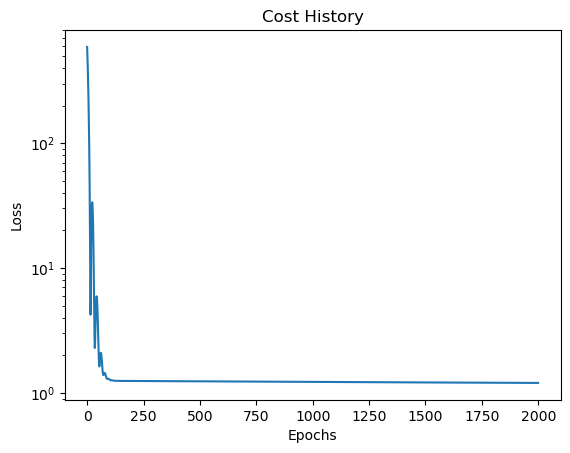

In [11]:
# Plot total net loss vs epochs
plt.plot(Total_loss)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cost History')

Text(0.5, 1.0, 'Cost History')

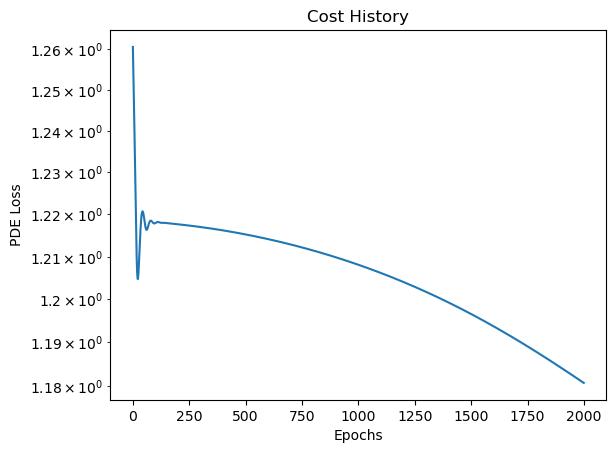

In [13]:
# Plot PDE loss vs epochs
plt.plot(PDE_loss)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('PDE Loss')
plt.title('Cost History')

Text(0.5, 1.0, 'Cost History')

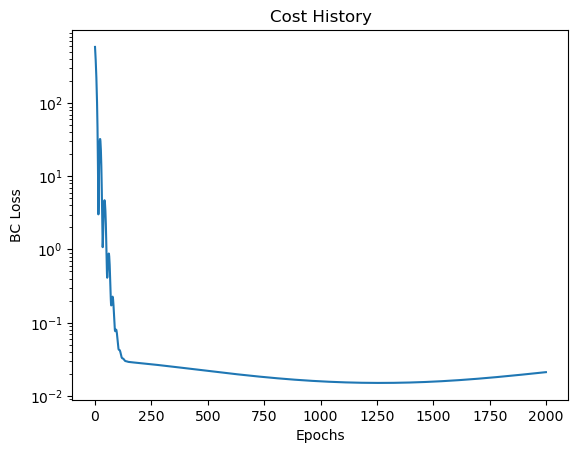

In [14]:
# Plot BC loss vs epochs
plt.plot(BC_loss)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('BC Loss')
plt.title('Cost History')

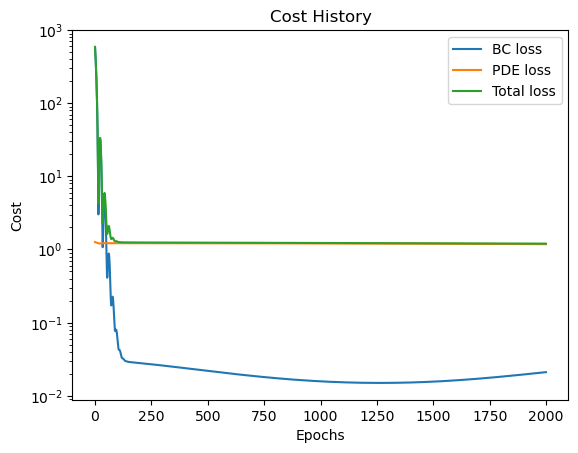

In [16]:
# Plot total loss, PDE loss and BC loss versus epochs
plt.plot(BC_loss,label = 'BC loss')
plt.plot(PDE_loss,label = 'PDE loss')
plt.plot(Total_loss,label = 'Total loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost History')
plt.legend()

## 4. Save the trained model (parameters) using ‘torch.save()’

In [17]:
torch.save(model.state_dict(), 'model_2000.pth')

### As we can see above plots were fairly unsatisfactory. We need more epochs to get better results. Let us train our data for 10000 epochs

In [22]:
extra_epochs = 8000

In [23]:
for epoch in range(extra_epochs):
    train(epoch+2001)

epoch 2100: loss_pde 1.17712235, loss_bc 0.00000226
epoch 2100: Total loss 1.19971371
epoch 2200: loss_pde 1.17350113, loss_bc 0.00000243
epoch 2200: Total loss 1.19784701
epoch 2300: loss_pde 1.16982150, loss_bc 0.00000262
epoch 2300: Total loss 1.19599628
epoch 2400: loss_pde 1.16607809, loss_bc 0.00000281
epoch 2400: Total loss 1.19413006
epoch 2500: loss_pde 1.16224837, loss_bc 0.00000300
epoch 2500: Total loss 1.19221556
epoch 2600: loss_pde 1.15829206, loss_bc 0.00000319
epoch 2600: Total loss 1.19021773
epoch 2700: loss_pde 1.15415132, loss_bc 0.00000339
epoch 2700: Total loss 1.18809819
epoch 2800: loss_pde 1.14975023, loss_bc 0.00000361
epoch 2800: Total loss 1.18580973
epoch 2900: loss_pde 1.14499116, loss_bc 0.00000383
epoch 2900: Total loss 1.18328822
epoch 3000: loss_pde 1.13974333, loss_bc 0.00000407
epoch 3000: Total loss 1.18043745
epoch 3100: loss_pde 1.13381946, loss_bc 0.00000433
epoch 3100: Total loss 1.17710280
epoch 3200: loss_pde 1.12692726, loss_bc 0.00000461
ep

## 1. Plot the displacement field contours in 𝑥− and 𝑦− directions after training the model.

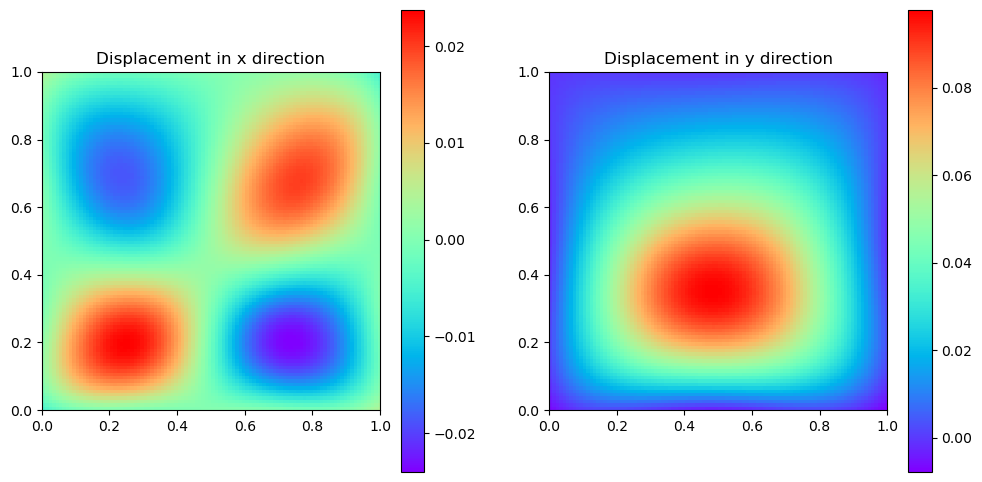

In [33]:
ui_preds = model.forward(xy_f_train)
ub_preds = model.forward(xy_b_train)
u_preds = torch.cat((ui_preds, ub_preds), dim = 0).detach().numpy()
u_plot = u_preds[:,0]
v_plot = u_preds[:,1]
xy_all = torch.cat((xy_f_train, xy_b_train), dim=0).detach().numpy()
x = xy_all[:,0]
y = xy_all[:,1]    
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)

# Interpolate the data onto the grid
U = griddata((x, y), u_plot, (X, Y), method='linear')
V = griddata((x, y), v_plot, (X, Y), method='linear')

# Plot the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
im1 = ax1.imshow(U, cmap='rainbow', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
im2 = ax2.imshow(V, cmap='rainbow', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

ax1.set_title('Displacement in x direction')
ax2.set_title('Displacement in y direction')
plt.show()

## 2. Plot the total loss, PDE loss and BC loss versus epochs.

Text(0.5, 1.0, 'Cost History')

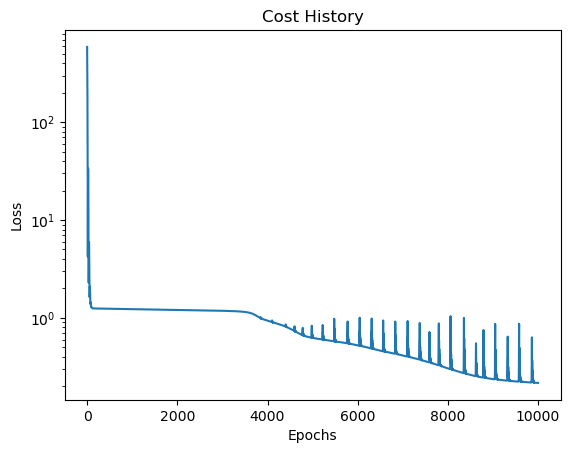

In [25]:
plt.plot(Total_loss)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cost History')

Text(0.5, 1.0, 'Cost History')

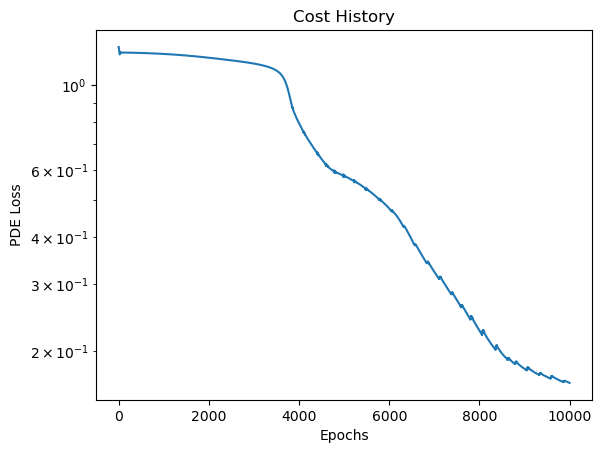

In [26]:
plt.plot(PDE_loss)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('PDE Loss')
plt.title('Cost History')

Text(0.5, 1.0, 'Cost History')

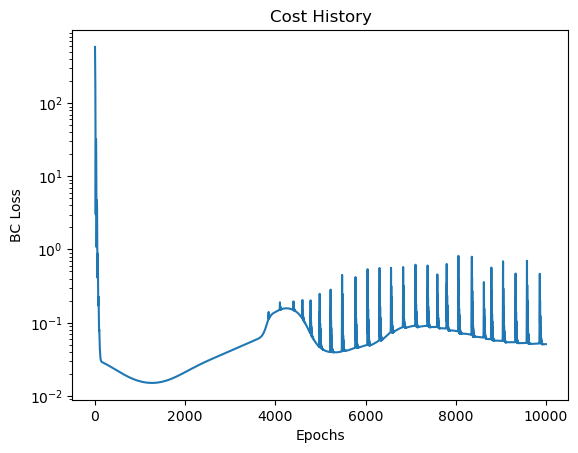

In [27]:
plt.plot(BC_loss)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('BC Loss')
plt.title('Cost History')

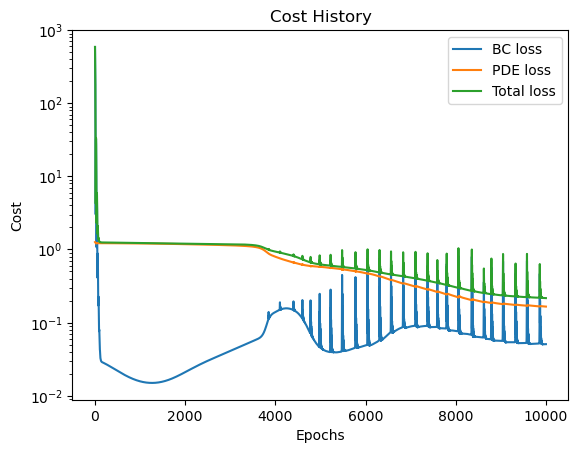

In [28]:
plt.plot(BC_loss,label = 'BC loss')
plt.plot(PDE_loss,label = 'PDE loss')
plt.plot(Total_loss,label = 'Total loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost History')
plt.legend()

## 3. Save the trained model (parameters) using ‘torch.save()’

In [32]:
torch.save(model.state_dict(), 'model_10000.pth')